<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_Study/blob/main/07_milstone_project_1_food_vision_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

What we're going to cover
* Using TensorFlow Datasets to download and explore data (all Food101)
* Creating a preparing function for our data
* Batching & preparing datasets for modelling (making them run fast)
* Setting up **mixed precision training** (faster model training)

### What does mixed precision training do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible.

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

Google Colab offers several kinds of GPU.(A100, T4, V100)

> As of May 2023, the GPUs available on Google Colab which allow mixed precision training are: NVIDIA A100 (available with Google Colab Pro)
NVIDIA Tesla T4


In [1]:
!pip uninstall -y tensorflow to remove the 2.12.x version

!pip install tensorflow==2.9.0
import tensorflow as tf
tf.__version__

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 62.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.

'2.9.0'

In [2]:
import matplotlib.pyplot as plt

## Check GPU

In order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+.

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e4b54db8-5d59-3332-2b4b-e86a6ed8cdff)


## Get helper functions

Load helper functions to avoid rebuilding the wheel.

The script is available: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-08-22 20:21:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-22 20:21:59 (84.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## TensorFlow dataset (TFDS) and download data

TensorFlow Datasets is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks, such as Jax. All datasets are exposed as `tf.data.Datasets` , enabling easy-to-use and high-performance input pipelines.

See the guid here: https://www.tensorflow.org/datasets/overview

Alldatasets include: audio, image, Abstractive text summarization, etc.

### Why use it?
* Load data already in tensor format
* Practice on well established datasets (for many different problem types)
* Experiment with different modelling techniques on a consistent dataset
### Why not use it?
* Datasets are static.

In this porject we're going to use [Food101](https://www.tensorflow.org/datasets/catalog/food101).

### Food101

> This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images

Source code: `tfds.image_classification.Food101`.  
Download size: 4.65 GiB.  
Feature Structure
```
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})
```

In [6]:
!pip install tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [7]:
# Get Tensorflow Datasets
import tensorflow_datasets as tfds

In [8]:
# List all available datasets
datasets_list = tfds.list_builders() # get all availabel datasets
print("food101" in datasets_list) # Check if our target dataset is in TFDS datasets

True


Be aware that some of the datasets in TFDS is very large, and be careful and **do your research before you download it**.

In [9]:
# TFDS allows you to use the datasets for modelling directly
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # we want label and data
                                             with_info=True)# download the metadata as well


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteW5US1O/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteW5US1O/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from Tensorflow datasets

To become one with the data:
* Class names
* The shape of our inputs
The datatype of our input data
* what the labels look like (e.g. are they one-hot encoded or label encoded)
* DO the labels match the class names?


In [10]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Take on sample
sample1 = train_data.take(1)
sample1


<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# Output info about our training sample
# Everytime we run this cell, it shuffle (effect of take())
for img, label in sample1:
  print(f"""
  Image shape: {img.shape},
  Image datatype: {img.dtype},
  Target class (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class (tensor form): 21,
  Class name (str form): chocolate_cake
  


So the target class isn't one-hot encoded, which means that we should use `sparse_crossentropy` for loss function when compiling.

In [14]:
# What does our image tensor from TFDS Food101 look like?
img

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 32,  14,   0],
        [ 31,  13,   0],
        [ 28,  12,   0],
        ...,
        [ 54,  34,  10],
        [ 53,  33,   9],
        [ 51,  31,   7]],

       [[ 28,  10,   0],
        [ 28,  10,   0],
        [ 27,  11,   0],
        ...,
        [ 56,  36,  12],
        [ 55,  35,  11],
        [ 54,  34,   9]],

       [[ 30,  12,   0],
        [ 31,  13,   0],
        [ 31,  15,   0],
        ...,
        [ 58,  38,  13],
        [ 58,  38,  13],
        [ 58,  38,  11]],

       ...,

       [[135,  80,   0],
        [136,  81,   1],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[137,  82,   2],
        [137,  82,   2],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[136,  81,   1],
        [135,  80,   0],
        [135,  80,   0],
        ...,
        [ 14,   7,   

In [15]:
# what are the min and max values of our image tensor?
tf.reduce_min(img), tf.reduce_max(img),

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot a image

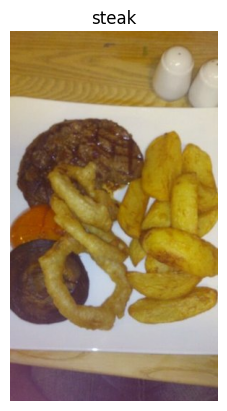

In [16]:
# Plot an image tensor
def plot_image(sample):
  """
  Plot an image, the input should be a sample from TFDS datasets
  """
  for img, label in sample:
    plt.imshow(img)
    plt.title(class_names[label.numpy()])
    plt.axis(False);

plot_image(sample1)

## Create preprocessing functions for our TFDS data

In the last notebooks (transfer learning), we use `image_dataset_from_directory`, which helps us split the dataset into batches and the same shape.

In order to get the data ready for neural network, you'll often have to write preprocessing functions and map it to your data.

Now we need to create preprocessing functions for TFDS data.

**What we know about TFDS data**:
* in `uint8` datatype
* different sized
* not scaled

**What we know models like**:
* Data in `float32` dtype (or `float16` and `float64`)
* For batches, TensorFlow likes all of the tensors within a batch to ba of the same size.
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With this points, we know a few things to fit in our preprocessing function.

> Since we're going to use an EfficientNetBX pretrained model from `rf.keras.applications` we don't need to rescale our data.

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`.


In [17]:
# Make a function for preprocessing
def preprocess_img(image, label, img_shape=224):
  '''
  convert image datatype from uint8 to float32
  reshape images to shape (img_shape, img_shape, color channels)
  '''
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label # return a tuple of (image(float32), label)



In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(img, label)[0]
print(f"Image before preprocessing:\n {img[:2]}...,\nShape: {img.shape},\nDatatype: {img.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[32 14  0]
  [31 13  0]
  [28 12  0]
  ...
  [54 34 10]
  [53 33  9]
  [51 31  7]]

 [[28 10  0]
  [28 10  0]
  [27 11  0]
  ...
  [56 36 12]
  [55 35 11]
  [54 34  9]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[29.19898    11.198979    0.        ]
  [28.285715   12.285714    0.        ]
  [30.852041   15.494898    0.28061217]
  ...
  [52.9336     32.505074    8.7193365 ]
  [54.025528   34.025528   10.025528  ]
  [53.800972   33.800972    9.571359  ]]

 [[33.09694    15.096939    1.193878  ]
  [33.785713   17.785715    2.785715  ]
  [31.785713   16.428572    1.2142859 ]
  ...
  [63.60206    42.530632   15.346998  ]
  [61.647934   40.7857     13.928558  ]
  [60.785713   41.714287   12.020403  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare dataset

We're going to make our data input pipeline run really fast.

See https://www.tensorflow.org/guide/data_performance (Highly recomended)

**All these efforts are to speed up our training.**


In [19]:
# Map preprocessing function to train data (and parallelize)
# Because the train_data is in form of tuple, so our preprocessing function take 2 input - (image, label)
# num_parallel_calls is to tell the computer to utilize all cpu as many as possible, which makes the preprocessing much faster
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it. Buffer_size - shuffle how many samples at a time.
# batch_size = 32 is a most used number.
# prefetch - when computing one batch, get another batch ready to go.
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing on test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Subconclusion
So what's going on above is that:
1. map the preprocessing function (self-defined) across our training dataset.
2. shuffle a number of elements (based on your computer's memory).
3. Batch them into 32 batches
4. Finally make sure you prepare new batches (prefetch) while the model is fitting on the current batch.

## Creating modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard
* ModelCheckpoint: save our model's progress after feature extraction
* EarlyStopping

In [21]:
# Create tensorboard callback(import from helper_function)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress
checkpoint_path = "model_checkpoint/checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

For deeper understanding of mixed precision training, check out https://www.tensorflow.org/guide/mixed_precision

Mixed precision utimizes a combination of float32 and float16 data type to speed up model performance. (can result in 3x speed up on modern GPUs)

In [22]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16") # set global policy to mixed precision
mixed_precision.set_global_policy("float32")

In [23]:
mixed_precision.global_policy()

<Policy "float32">

## Build feature extraction model

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: efficientNetX models have rescalling layer built-in, if your model doesn't have rescalling layer.
# x = preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
# what changes with mixed precision
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# compile the model
# if your data labels are integer value, you should use SparseCategoricalCrossentropy.
# If the labels are in one-hot encoded, you should use categorical_crossentropy
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"]
              )

16705208/16705208 [==============================] - 0s 0us/step


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies(are we using mixed precision?)

In [26]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


The above info tell us that:
* `layer_name`: the human readable name of particular layer
* `layer_trainable`: is the layer trainable or not.
* `layer.dtype`: the data type in which a layer stores its variable
* `layer.dtype_policy`: the data type policy that a layer computes on its variables with

In [27]:
# Check above attributes of layers in base_model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


## Fit the fearure extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature-extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [28]:
# Fit the feature extraction model with callbacks
history_101_food_feature_extraction = model.fit(train_data,
                                                epochs=3,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=int(0.15*len(test_data)),
                                                callbacks=[create_tensorboard_callback(dir_name="training_log",
                                                                                       experiment_name="efficientnetb0_Food101_feature_extraction"),
                                                           model_checkpoint])

Saving TensorBoard log files to: training_log/efficientnetb0_Food101_feature_extraction/20230822-203508
Epoch 1/3
2368/2368 [==============================] - 243s 96ms/step - loss: 1.7174 - accuracy: 0.5825 - val_loss: 1.1349 - val_accuracy: 0.6999
Epoch 2/3
2368/2368 [==============================] - 226s 93ms/step - loss: 1.1983 - accuracy: 0.6893 - val_loss: 1.0328 - val_accuracy: 0.7246
Epoch 3/3
2368/2368 [==============================] - 235s 98ms/step - loss: 1.0549 - accuracy: 0.7236 - val_loss: 0.9948 - val_accuracy: 0.7272


In [29]:
# Evaluate model on whole test dataset
results_feature_extraction = model.evaluate(test_data)
results_feature_extraction

790/790 [==============================] - 80s 101ms/step - loss: 0.9999 - accuracy: 0.7278


[0.9998862743377686, 0.7278415560722351]

Before fine-tuning, we get a result of 72.7% accuracy. Now we save this model.

## Save and load the model

In [42]:
model.save("/content/drive/MyDrive/tf_models/Food101_feature_extraction")

In [43]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/tf_models/Food101_feature_extraction')
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [44]:
results_loaded_model = loaded_model.evaluate(test_data)
results_loaded_model

790/790 [==============================] - 74s 91ms/step - loss: 1.0032 - accuracy: 0.7278


[1.0032298564910889, 0.7278019785881042]

## Fine-tune with my own model

Where my food101_all_feature_extraction model saved: /content/drive/MyDrive/tf_models/Food101_feature_extraction


In [31]:
# unfreeze all layers in the base model
for layer in model.layers:
  layer.trainable=True
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetb0 True <Policy "float32">
global_average_pooling2d True <Policy "float32">
dense True <Policy "float32">
softmax_float32 True <Policy "float32">


### Set up callbacks
```python
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")
                                     
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)
```

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)
checkpoint_path = "fine_tune_ckp_all"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [40]:
# Recompile
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [41]:
history_fine_tune_all_Food101_self = model.fit(train_data, epochs=100,
                                               steps_per_epoch=len(train_data),
                                               validation_data=test_data,
                                               validation_steps=int(0.15*len(test_data)),
                                               callbacks=[create_tensorboard_callback("training_log",
                                                                                 "efficientnetb0_Food101_fine_tune_all_self"),
                                                     model_checkpoint,
                                                     early_stopping,
                                                     reduce_lr])

Saving TensorBoard log files to: training_log/efficientnetb0_Food101_fine_tune_all_self/20230822-210405
Epoch 1/100
2368/2368 [==============================] - 823s 340ms/step - loss: 0.8695 - accuracy: 0.7656 - val_loss: 0.7659 - val_accuracy: 0.7865 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 788s 331ms/step - loss: 0.5386 - accuracy: 0.8499 - val_loss: 0.7507 - val_accuracy: 0.7871 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 789s 332ms/step - loss: 0.3010 - accuracy: 0.9142 - val_loss: 0.8376 - val_accuracy: 0.7892 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9534
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 792s 333ms/step - loss: 0.1577 - accuracy: 0.9534 - val_loss: 0.9153 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 791s 333ms/

In [42]:
model.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.0350 - accuracy: 0.8018


[1.0349693298339844, 0.8017821907997131]

### Save self model

In [43]:
model.save("/content/drive/MyDrive/tf_models/all_food101_efficientnetb0_fine_tune_self")


In [46]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tf_models/all_food101_efficientnetb0_fine_tune_self")

In [47]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 72s 89ms/step - loss: 1.0350 - accuracy: 0.8018


[1.0349698066711426, 0.8017821907997131]

So after fine-tune all layers of EfficientNetB0, we can get an accuracy of nearly 80%.

## Fine-tune the model (use model trained by ZTM)

The following fine-tuning uses the model trained by Mr. dbourke.

In [57]:
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

In [45]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2023-08-22 01:24:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  15.0MB/s    in 1.1s    

2023-08-22 01:24:11 (15.0 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [46]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

results_loaded_model = model.evaluate(test_data)

In [48]:
# results of model trained in course.
results_loaded_model

[1.0881030559539795, 0.7065346240997314]

In [49]:
results_feature_extraction

[1.0032299757003784, 0.7278019785881042]

In [50]:
# set all the layers in loaded model trainable
for layer in model.layers:
  layer.trainable=True
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


In [51]:
# check the trainable layers in base_model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True


So here we can see all layers in base model is trainable. What we're going to do next is to setup callbacks:
1. `EarlyStopping`
2. `ModelCheckpoint`

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [58]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

**Here introducing another callback function: `ReduceLROnPlateau`**, which helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

> The reasoning is that imaging that you're finding a spot and you search the spot on phone map. You're following the map and getting closer to your destination. But when you're getting closer, you will tend to slow your speed or take smaller steps so that you would not miss the spot.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [59]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [60]:
# Compile the model for fine-tuning
# Remember to lower the training rate of Adam opyimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [61]:
# Start fine-tuning (all layers)
# Use 80 epochs as default
# Validate on 15% of test data
history_fine_tune_all_Food101 = model.fit(train_data,
                                          epochs=80,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          callbacks=[create_tensorboard_callback("training_log",
                                                                                 "efficientnetb0_Food101_fine_tune_all"),
                                                     model_checkpoint,
                                                     early_stopping,
                                                     reduce_lr])

Saving TensorBoard log files to: training_log/efficientnetb0_Food101_fine_tune_all/20230822-015944
Epoch 1/80
2368/2368 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9543

2368/2368 [==============================] - 442s 178ms/step - loss: 0.1503 - accuracy: 0.9543 - val_loss: 0.9931 - val_accuracy: 0.7858 - lr: 1.0000e-04
Epoch 2/80
2368/2368 [==============================] - 386s 162ms/step - loss: 0.1000 - accuracy: 0.9680 - val_loss: 1.1112 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 3/80
2368/2368 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9751
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 371s 155ms/step - loss: 0.0786 - accuracy: 0.9751 - val_loss: 1.1661 - val_accuracy: 0.7783 - lr: 1.0000e-04
Epoch 4/80
2368/2368 [==============================] - 368s 154ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 1.1755 - val_accuracy: 0.8046 - lr: 2.0000e-05


In [62]:
# Evaluate the fine-tuned model on whole test data
results_fine_tune_all_Food101 = model.evaluate(test_data)
results_fine_tune_all_Food101

790/790 [==============================] - 63s 80ms/step - loss: 1.1965 - accuracy: 0.7975


[1.1965110301971436, 0.797544538974762]

Excellent! We got almost 80% accuracy.

**Note:** `EarlyStopping` and `ReduceLROnPlateau` are really a useful pair.

## Save the fine-tuned model

In [100]:
model.save("/content/drive/MyDrive/tf_models/all_food101_efficientnetb0_fine_tune")


In [70]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tf_models/Food101_feature_extraction")

In [71]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 80s 97ms/step - loss: 1.0032 - accuracy: 0.7278


[1.0032291412353516, 0.7278019785881042]

In [72]:
results_feature_extraction

[1.0032299757003784, 0.7278019785881042]

In [ ]:
loaded_model_all = tf.keras.models.load_model("/content/drive/MyDrive/tf_models/All_food101_efficientnetb0_fine_tune")

/content/drive/MyDrive/tf_models/All_food101_efficientnetb0_fine_tune

## Create TensorBoard to view training results

In [93]:
!pip install -U tensorboard
!tensorboard --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.0 requires tensorboard<2.10,>=2.9, but you have tens

2.14.0


In [94]:
# Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_log \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_log

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VYV-PQR-JZY



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/kIo72WbGQ5ODUwnjBZW0Kw/

[2023-08-19T23:06:17] Started scanning logdir.
[2023-08-19T23:06:24] Total uploaded: 96 scala

In [95]:
!tensorboard dev list

https://tensorboard.dev/experiment/kIo72WbGQ5ODUwnjBZW0Kw/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   kIo72WbGQ5ODUwnjBZW0Kw
	Created              2023-08-19 23:06:17 (12 seconds ago)
	Updated              2023-08-19 23:06:24 (5 seconds ago)
	Runs                 8
	Tags                 5
	Scalars              96
	Tensor bytes         0
	Binary object bytes  6101022
https://tensorboard.dev/experiment/ROOFkeT1TBKHpzpqFoRatQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amount of data
	Id                   ROOFkeT1TBKHpzpqFoRatQ
	Created              2023-08-17 18:59:34
	Updated              2023-08-17 18:59:45
	Runs                 12
	Tags                 5
	Scalars              192
	Tensor bytes         0
	Binar

In [ ]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID